In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import json

In [2]:
df = pd.read_pickle("citibikedata/9000timeslots.pickle")
# Please note that some unused columns were deleted.
# However, in all other respects the pickled data was "raw".
# Row cleaning had not yet taken place.

In [3]:
TARGETSTATION = '465'   # Station IDs are strings

In [4]:
df.dtypes

is_installed            int32
is_renting              int32
is_returning            int32
last_reported           int32
num_bikes_available     int32
num_bikes_disabled      int32
num_docks_available     int32
num_docks_disabled      int32
station_id             object
ts                      int64
dtype: object

In [5]:
# Houston we have a problem!
# We are getting files with "last_reported" of ZERO so those must be filtered out of the dataframe first.
df = df[df['last_reported'] > 1000]

In [6]:
# OK now the df is clean of bad timestamps in the "last_reported" column.
# Converting from typical second-granularity epoch timestamp requires unit='s'
df['most_recent_conn_DT'] = pd.to_datetime(df['last_reported'], unit='s')

In [7]:
# The shape of a dataframe is its row count x column count
df.dtypes

is_installed                    int32
is_renting                      int32
is_returning                    int32
last_reported                   int32
num_bikes_available             int32
num_bikes_disabled              int32
num_docks_available             int32
num_docks_disabled              int32
station_id                     object
ts                              int64
most_recent_conn_DT    datetime64[ns]
dtype: object

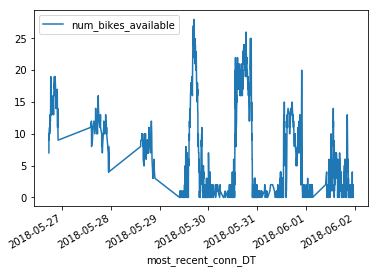

In [8]:
#A successful plotting of just one station:
df[df['station_id']==TARGETSTATION].plot(x='most_recent_conn_DT', y=['num_bikes_available'])

# 1: STATIONS WITH MOST "volatility"

Every station sends its reports to HQ only sporadically, not on a fixed schedule.

So as a quick measure of volatility of station S, we could take the time-sorted signatures for station S, and determine the velocity between each adjacent pair S[i] and S[i+1], and compute the sum of the velocities.

The velocity could simply be the sum, across all columns C, of abs(S[i][c] - S[i+1][c]).  The will as desired produce a velocity of zero if two adjacent reports actually had no net change to report.

We could mute the velocity by the duration between S[i] and S[i+1] but this isn't really necessary since max(i) itself will be higher for the highest-active stations anyway, so they will naturally have more velocities being summed.

## 1.1:  "QuickVolatility"

The quickest approach to computing volatility would be to simply produce the count of individual report rows per station.  There is already a great deal
of spread on that particular metric.

Let's compute a histogram based on QuickVolatility!


In [9]:
df = df.drop(columns=['is_installed','is_renting','is_returning','ts'], 
             errors='ignore')

In [10]:
df.dtypes

last_reported                   int32
num_bikes_available             int32
num_bikes_disabled              int32
num_docks_available             int32
num_docks_disabled              int32
station_id                     object
most_recent_conn_DT    datetime64[ns]
dtype: object

In [11]:
df.shape

(7247553, 7)

In [12]:
df = df.drop_duplicates()

In [13]:
df.shape

(646984, 7)

In [14]:
df.sort_values(by=['station_id','most_recent_conn_DT'], inplace=True)

In [15]:
# This will create an obj of type DataFrameGroupBy
per_station_info = df.groupby('station_id')

In [29]:
# OK so there are supposedly only 845 stations!
# But as you can see, we have much more!
per_station_info.ngroups

1614

In [30]:
per_station_info.groups

{72: Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
             ...
             0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
            dtype='int64', length=212),
 79: Int64Index([1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
             ...
             1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
            dtype='int64', length=121),
 82: Int64Index([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
             2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2],
            dtype='int64'),
 83: Int64Index([3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
             ...
             3, 3, 3, 3, 3, 3, 3, 3, 3, 3],
            dtype='int64', length=131),
 119: Int64Index([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
             4, 4, 4, 4, 4, 4, 4, 4],
            dtype='int64'),
 120: Int64Index([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
             5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5375775278>]], dtype=object)

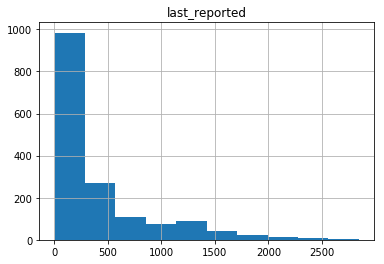

In [24]:
# TRIVIAL  "QuickVolatility" is just the count per station.
per_station_info.count().hist(column='last_reported',bins=10)

In [25]:
# What are the top 10 stations in QuickVolatility?
df_station_to_quickvol = per_station_info.count()

In [26]:
df_station_to_quickvol.sort_values(by='last_reported', ascending=False)

,last_reported,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,most_recent_conn_DT
station_id,,,,,,
519,2845,2845,2845,2845,2845,2845
435,2573,2573,2573,2573,2573,2573
497,2526,2526,2526,2526,2526,2526
402,2495,2495,2495,2495,2495,2495
426,2450,2450,2450,2450,2450,2450
490,2403,2403,2403,2403,2403,2403
482,2372,2372,2372,2372,2372,2372
281,2336,2336,2336,2336,2336,2336
477,2330,2330,2330,2330,2330,2330


In [ ]:
df.dtypes

Let's find out exactly how much data we have.  The granularity is per minute, but what is the range?


In [172]:
df['ts'].min()

Timestamp('2018-05-26 17:23:11')

In [173]:
df['ts'].max()

Timestamp('2018-06-01 23:22:05')

In [174]:
df['ts'].max() - df['ts'].min()

Timedelta('6 days 05:58:54')